In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

## Conv BatchNorm ReLU block

In [42]:
def conv_batchnorm_relu(x, filters, kernel_size, strides):
    x = layers.Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

## Identity block

In [43]:
def identity_block(tensor, filters):
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = layers.Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)  # notice: filters=4*filters
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, tensor])
    x = layers.ReLU()(x)
    return x

## Projection block

In [44]:
def projection_block(tensor, filters, strides):
    # left stream
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=strides)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = layers.Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)  # notice: filters=4*filters
    x = layers.BatchNormalization()(x)

    # right stream
    shortcut = layers.Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)  # notice: filters=4*filters
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

## ResNet Block

In [45]:
def resnet_block(x, filters, reps, strides):
    x = projection_block(x, filters=filters, strides=strides)
    for _ in range(reps-1):  # the -1 is because the first block was a Conv one
        x = identity_block(x, filters=filters)
    return x

## Define Model

In [46]:
inputs=layers.Input(shape=(224,224,3))

In [47]:
x=conv_batchnorm_relu(inputs,filters=64,kernel_size=7,strides=2)
x=layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)

In [48]:
x=resnet_block(x,filters=64,reps=3,strides=1)
x=resnet_block(x,filters=128,reps=4,strides=2)
x=resnet_block(x,filters=256,reps=6,strides=2)
x=resnet_block(x,filters=512,reps=3,strides=2)

In [49]:
x=layers.GlobalAvgPool2D()(x)

In [50]:
output=layers.Dense(1000,activation='softmax')(x)

In [51]:
model=keras.Model(inputs,output)

## Analysis ResNet Model

In [52]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 112, 112, 64) 256         conv2d_46[0][0]                  
__________________________________________________________________________________________________
re_lu_30 (ReLU)                 (None, 112, 112, 64) 0           batch_normalization_46[0][0]     
_______________________________________________________________________________________

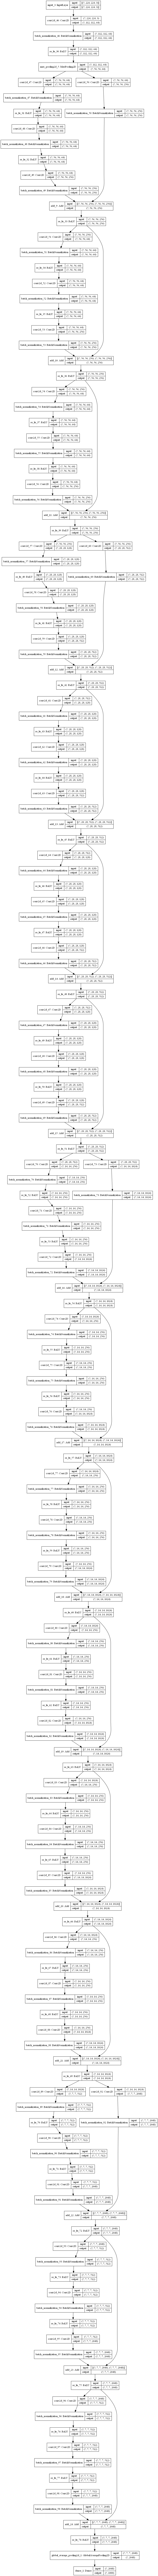

In [53]:
keras.utils.plot_model(model,to_file='ResNet_Model.png',show_shapes=True)